In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
from astral import LocationInfo
from astral.sun import daylight
from sklearn.kernel_ridge import KernelRidge

In [2]:
data = pd.read_parquet(Path('data') / 'train.parquet')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [4]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [5]:
d = SchoolHolidayDates()
jf = JoursFeries()
data['hour'] = data.date.dt.hour
data['weekday'] = data.date.dt.weekday
data['dom'] = data.date.dt.day
data['week'] = data.date.dt.isocalendar().week
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year
data['dom_counter'] = data.counter_installation_date.dt.day
data['month_counter'] = data.counter_installation_date.dt.month
data['year_counter'] = data.counter_installation_date.dt.year
data['date_datetime'] = data.date.map(lambda x: x.to_pydatetime().date())
data['is_ferie'] = data.date_datetime.map(lambda x: jf.is_bank_holiday(x, zone='Métropole'))
data['is_holiday'] = data.date_datetime.map(lambda x: d.is_holiday_for_zone(x, 'C'))

In [6]:
city = LocationInfo('Paris', timezone='Europe/Paris')
sun_info = daylight(city.observer, date=data.date_datetime.iloc[0], tzinfo='Europe/Paris')
sun_info_2 = daylight(city.observer, date=date(2020, 12, 12), tzinfo='Europe/Paris')

In [7]:
print(sun_info_2)

(datetime.datetime(2020, 12, 12, 8, 57, 4, 407014, tzinfo=<DstTzInfo 'Europe/Paris' CET+1:00:00 STD>), datetime.datetime(2020, 12, 12, 16, 50, 39, 533405, tzinfo=<DstTzInfo 'Europe/Paris' CET+1:00:00 STD>))


In [8]:
current_time = data.date.iloc[0]
current_time.to_pydatetime()
current_time.tz_localize('Europe/Paris') > sun_info[0]

False

In [9]:
def is_daylight(x):
    city=LocationInfo('Paris', timezone='Europe/Paris')
    sun_info = daylight(city.observer, date=x.to_pydatetime().date(), tzinfo='Europe/Paris')
    x = x.tz_localize('Europe/Paris', ambiguous=True, nonexistent='shift_forward')
    return (x > sun_info[0]) & (x < sun_info[1])

In [10]:
data['is_daylight'] = data.date.map(is_daylight)

In [11]:
data.drop(columns=['counter_name', 'site_name', 'counter_technical_id', 'counter_installation_date'], inplace=True)

In [12]:
data.head()

,counter_id,site_id,bike_count,date,latitude,longitude,log_bike_count,hour,weekday,dom,week,month,year,dom_counter,month_counter,year_counter,date_datetime,is_ferie,is_holiday,is_daylight
48321,100007049-102007049,100007049,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,2,1,1,36,9,2020,18,1,2013,2020-09-01,False,False,False
48324,100007049-102007049,100007049,1.0,2020-09-01 03:00:00,48.846028,2.375429,0.693147,3,1,1,36,9,2020,18,1,2013,2020-09-01,False,False,False
48327,100007049-102007049,100007049,0.0,2020-09-01 04:00:00,48.846028,2.375429,0.000000,4,1,1,36,9,2020,18,1,2013,2020-09-01,False,False,False
48330,100007049-102007049,100007049,4.0,2020-09-01 15:00:00,48.846028,2.375429,1.609438,15,1,1,36,9,2020,18,1,2013,2020-09-01,False,False,True
48333,100007049-102007049,100007049,9.0,2020-09-01 18:00:00,48.846028,2.375429,2.302585,18,1,1,36,9,2020,18,1,2013,2020-09-01,False,False,True


C:\Users\natha\AppData\Local\Temp/ipykernel_11156/3961394203.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


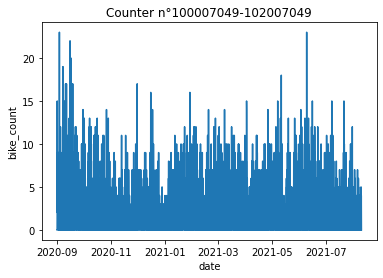

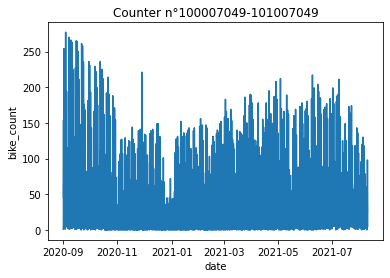

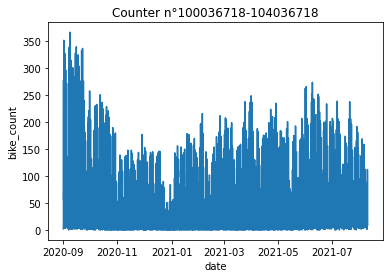

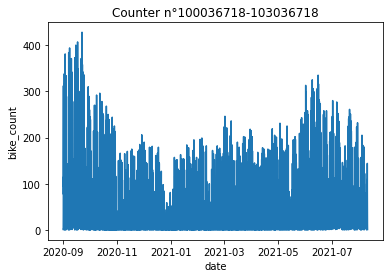

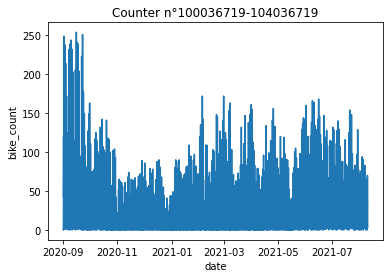

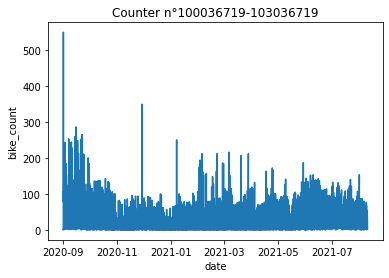

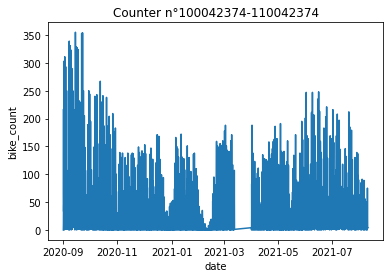

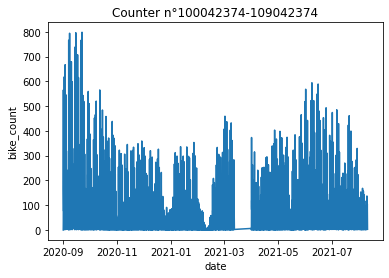

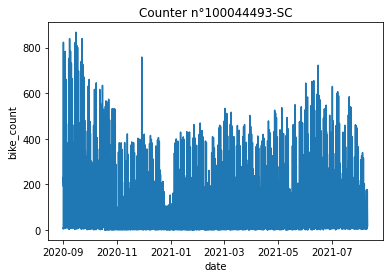

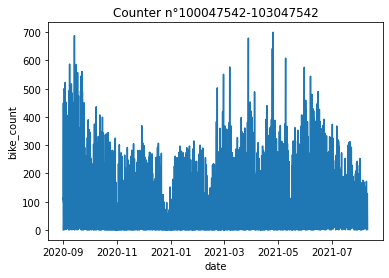

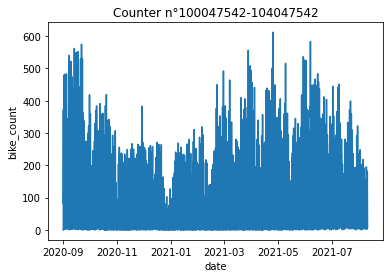

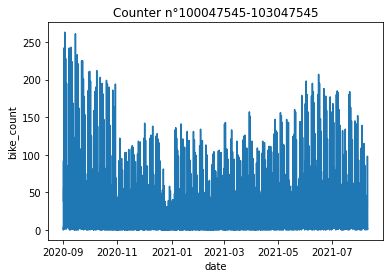

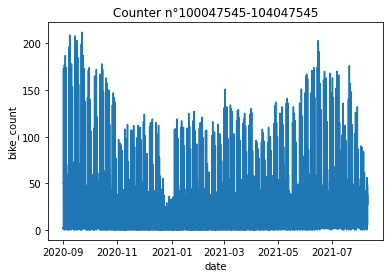

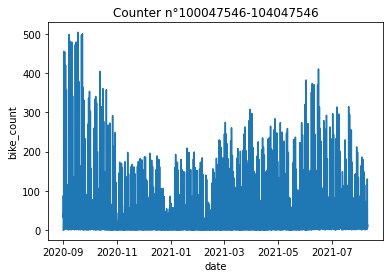

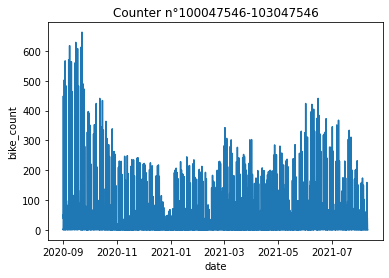

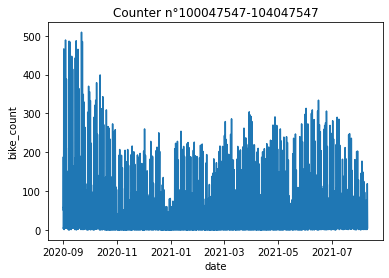

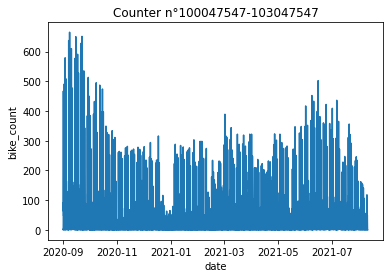

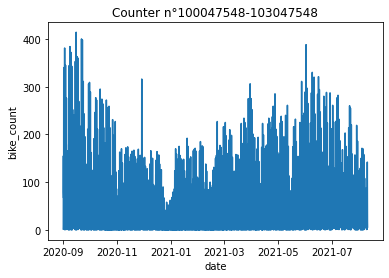

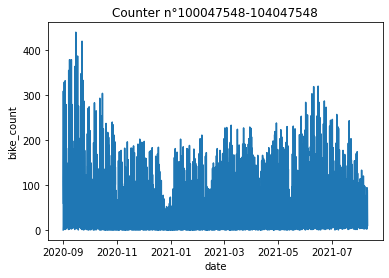

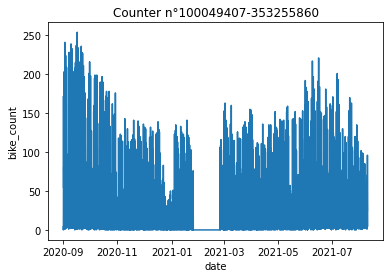

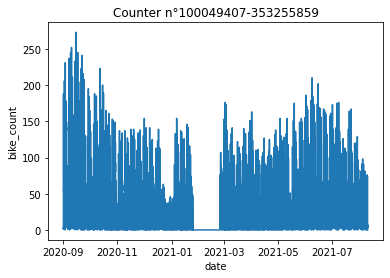

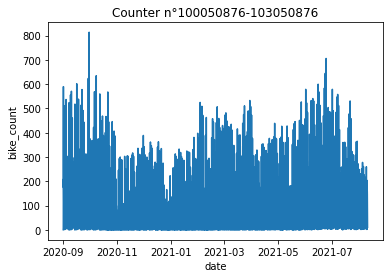

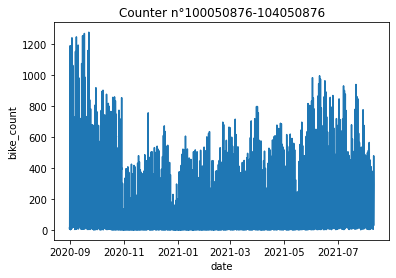

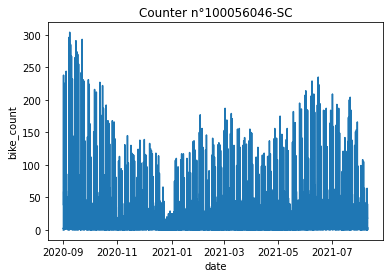

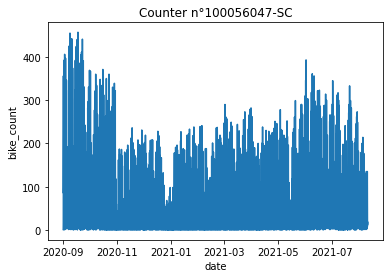

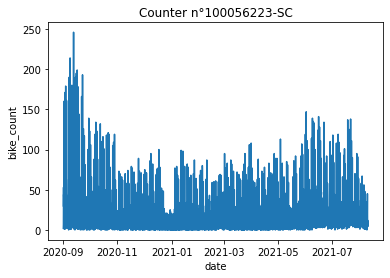

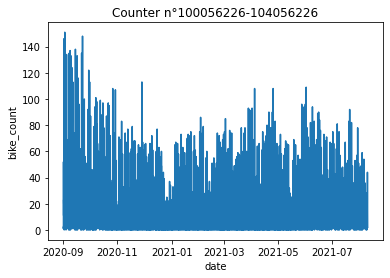

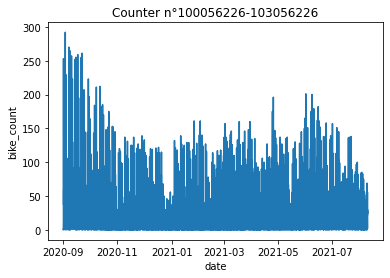

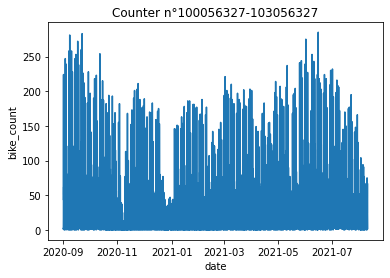

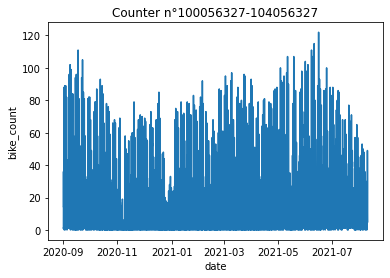

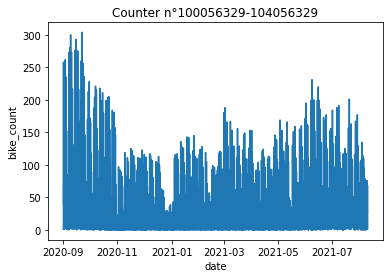

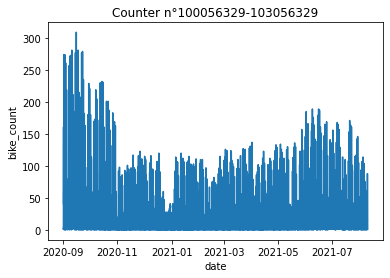

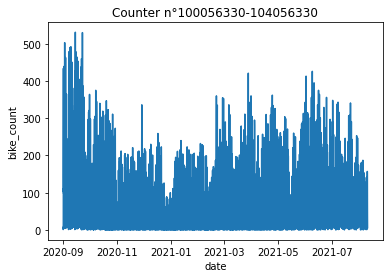

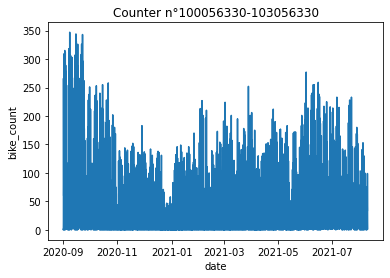

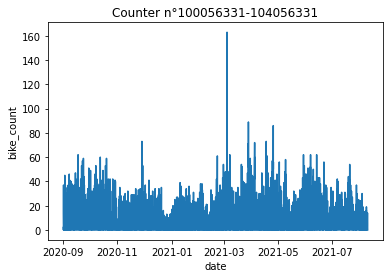

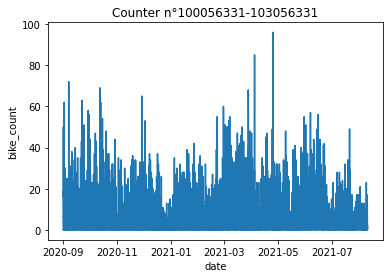

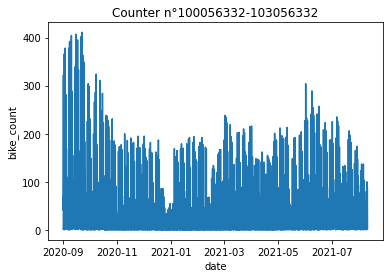

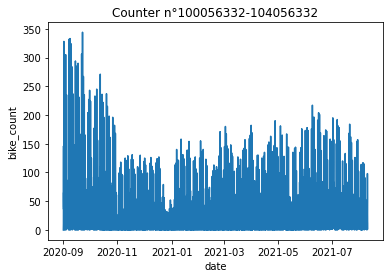

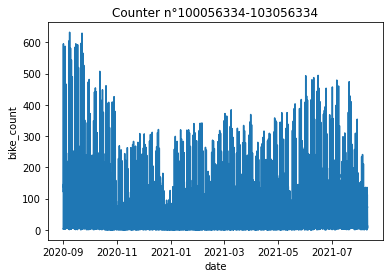

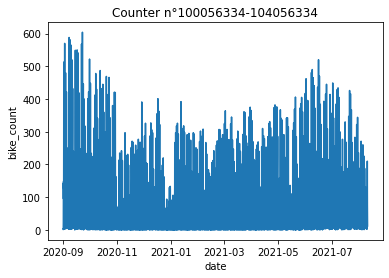

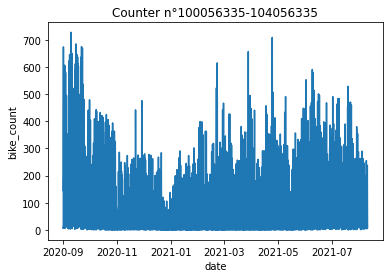

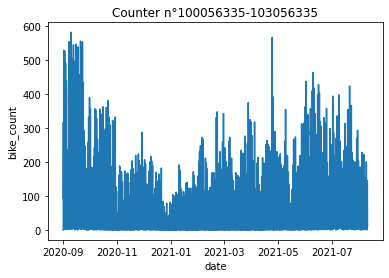

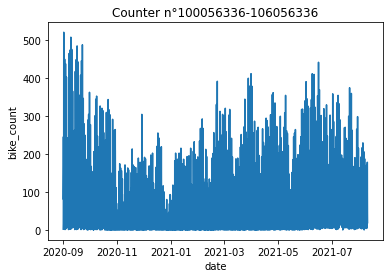

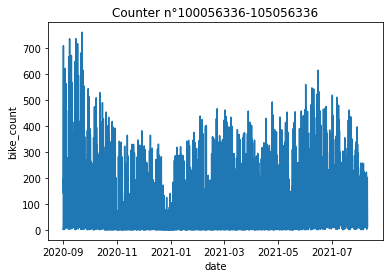

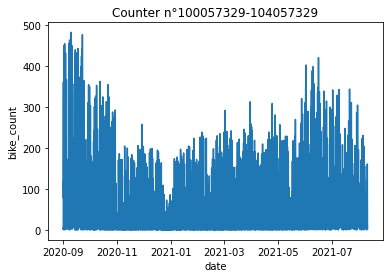

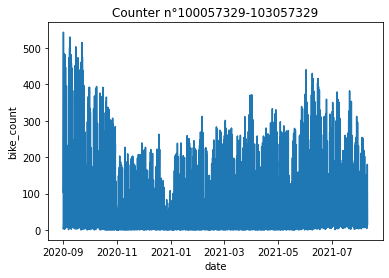

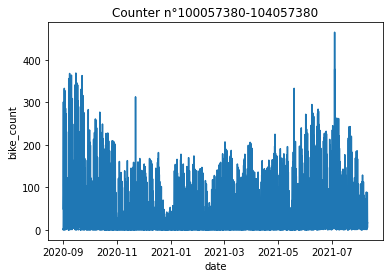

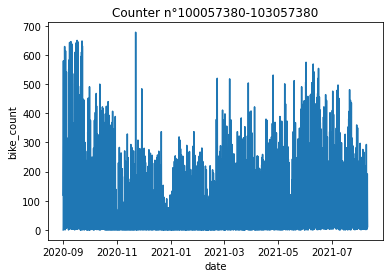

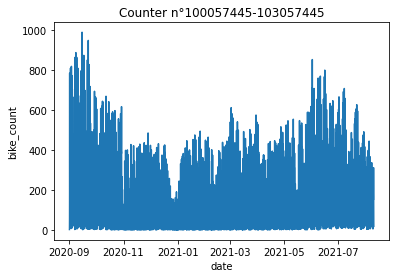

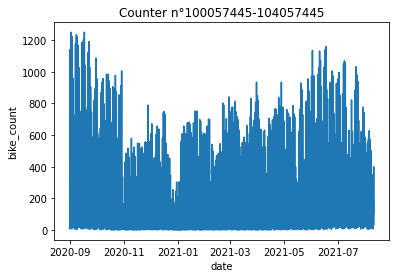

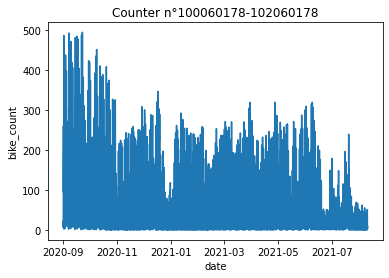

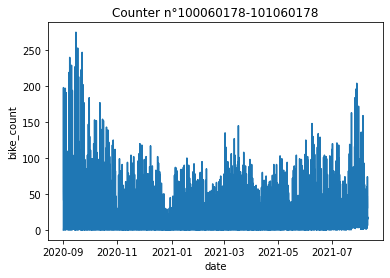

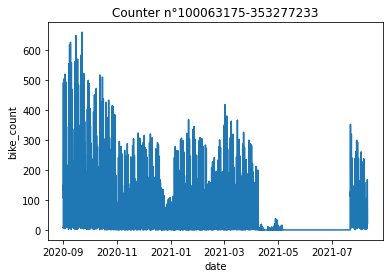

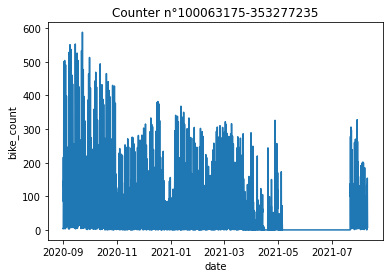

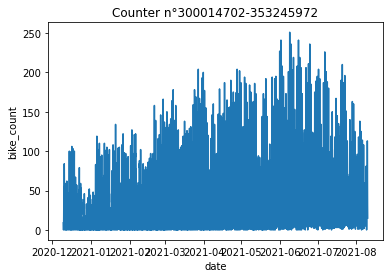

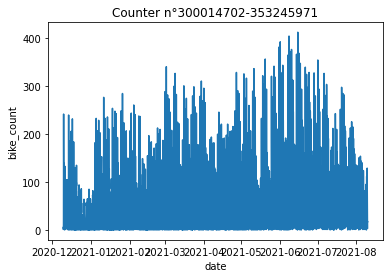

In [13]:
counter_ids = data.counter_id.unique()

for i in counter_ids:
    fig = plt.figure()
    sns.lineplot(x='date', y='bike_count', data=data[data.counter_id == i])
    plt.title(f'Counter n°{i}')
    plt.plot()

In [14]:
data_points = []
for i, counter in enumerate(counter_ids) :
    num_counter = data[data.counter_id == counter].shape[0]
    data_points.append([counter, num_counter])

table = pd.DataFrame(data_points, columns=['counter_id', 'number of data points'])
print(table)


             counter_id  number of data points
0   100007049-102007049                   8230
1   100007049-101007049                   8230
2   100036718-104036718                   8230
3   100036718-103036718                   8230
4   100036719-104036719                   8230
5   100036719-103036719                   8230
6   100042374-110042374                   7775
7   100042374-109042374                   7775
8          100044493-SC                   8230
9   100047542-103047542                   8230
10  100047542-104047542                   8230
11  100047545-103047545                   8230
12  100047545-104047545                   8230
13  100047546-104047546                   8230
14  100047546-103047546                   8230
15  100047547-104047547                   8230
16  100047547-103047547                   8230
17  100047548-103047548                   8230
18  100047548-104047548                   8230
19  100049407-353255860                   8224
20  100049407

In [15]:
data_points = []
for i, counter in enumerate(counter_ids) :
    num_null = data[(data.counter_id == counter) & (data.bike_count == 0)].shape[0]
    data_points.append([counter, num_null])

table = pd.DataFrame(data_points, columns=['counter_id', 'number of data points'])
print(table)

             counter_id  number of data points
0   100007049-102007049                   2862
1   100007049-101007049                    263
2   100036718-104036718                    420
3   100036718-103036718                    694
4   100036719-104036719                    834
5   100036719-103036719                    627
6   100042374-110042374                    900
7   100042374-109042374                    576
8          100044493-SC                    105
9   100047542-103047542                    329
10  100047542-104047542                    227
11  100047545-103047545                    511
12  100047545-104047545                    630
13  100047546-104047546                    596
14  100047546-103047546                    800
15  100047547-104047547                    479
16  100047547-103047547                    889
17  100047548-103047548                    557
18  100047548-104047548                    309
19  100049407-353255860                   1077
20  100049407

In [16]:
data_grouped = data.groupby(by=['counter_id', 'date_datetime']).sum()
data_grouped.head()

site_id  bike_count     latitude  \
counter_id          date_datetime                                        
100007049-101007049 2020-09-01     2300162127      1669.0  1123.458644   
                    2020-09-02     2400169176      1760.0  1172.304672   
                    2020-09-03     2400169176      1880.0  1172.304672   
                    2020-09-04     2400169176      1736.0  1172.304672   
                    2020-09-05     2400169176      1207.0  1172.304672   

                                   longitude  log_bike_count  hour  weekday  \
counter_id          date_datetime                                             
100007049-101007049 2020-09-01     54.634867       86.698526   276       23   
                    2020-09-02     57.010296       90.306657   276       48   
                    2020-09-03     57.010296       90.912423   276       72   
                    2020-09-04     57.010296       94.174095   276       96   
                    2020-09-05     57.010296       88.180206   276      120   

                                   dom  week  month   year  dom_counter  \
counter_id          date_datetime                                         
100007049-101007049 2020-09-01      23   828    207  46460          414   
                    2020-09-02      48   864    216  48480          432   
                    2020-09-03      72   864    216  48480          432   
                    2020-09-04      96   864    216  48480          432   
                    2020-09-05     120   864    216  48480          432   

                                   month_counter  year_counter  is_ferie  \
counter_id          date_datetime                                          
100007049-101007049 2020-09-01                23         46299         0   
                    2020-09-02                24         48312         0   
                    2020-09-03                24         48312         0   
                    2020-09-04                24         48312         0   
                    2020-09-05                24         48312         0   

                                   is_holiday  is_daylight  
counter_id          date_datetime                           
100007049-101007049 2020-09-01              0           13  
                    2020-09-02              0           13  
                    2020-09-03              0           13  
                    2020-09-04              0           13  
                    2020-09-05              0           13

In [17]:
data_grouped[data_grouped.bike_count == 0]

site_id  bike_count  latitude  longitude  \
counter_id          date_datetime                                             
100042374-109042374 2021-03-13           0         0.0       0.0        0.0   
                    2021-03-14           0         0.0       0.0        0.0   
                    2021-03-15           0         0.0       0.0        0.0   
                    2021-03-16           0         0.0       0.0        0.0   
                    2021-03-17           0         0.0       0.0        0.0   
...                                    ...         ...       ...        ...   
300014702-353245972 2020-12-04           0         0.0       0.0        0.0   
                    2020-12-05           0         0.0       0.0        0.0   
                    2020-12-06           0         0.0       0.0        0.0   
                    2020-12-07           0         0.0       0.0        0.0   
                    2020-12-08           0         0.0       0.0        0.0   

                                   log_bike_count  hour  weekday  dom  week  \
counter_id          date_datetime                                             
100042374-109042374 2021-03-13                0.0     0        0    0     0   
                    2021-03-14                0.0     0        0    0     0   
                    2021-03-15                0.0     0        0    0     0   
                    2021-03-16                0.0     0        0    0     0   
                    2021-03-17                0.0     0        0    0     0   
...                                           ...   ...      ...  ...   ...   
300014702-353245972 2020-12-04                0.0     0        0    0     0   
                    2020-12-05                0.0     0        0    0     0   
                    2020-12-06                0.0     0        0    0     0   
                    2020-12-07                0.0     0        0    0     0   
                    2020-12-08                0.0     0        0    0     0   

                                   month  year  dom_counter  month_counter  \
counter_id          date_datetime                                            
100042374-109042374 2021-03-13         0     0            0              0   
                    2021-03-14         0     0            0              0   
                    2021-03-15         0     0            0              0   
                    2021-03-16         0     0            0              0   
                    2021-03-17         0     0            0              0   
...                                  ...   ...          ...            ...   
300014702-353245972 2020-12-04         0     0            0              0   
                    2020-12-05         0     0            0              0   
                    2020-12-06         0     0            0              0   
                    2020-12-07         0     0            0              0   
                    2020-12-08         0     0            0              0   

                                   year_counter  is_ferie  is_holiday  \
counter_id          date_datetime                                       
100042374-109042374 2021-03-13                0         0           0   
                    2021-03-14                0         0           0   
                    2021-03-15                0         0           0   
                    2021-03-16                0         0           0   
                    2021-03-17                0         0           0   
...                                         ...       ...         ...   
300014702-353245972 2020-12-04                0         0           0   
                    2020-12-05                0         0           0   
                    2020-12-06                0         0           0   
                    2020-12-07                0         0           0   
                    2020-12-08                0         0           0   

              

In [18]:
counter_down = data_grouped[data_grouped.bike_count == 0].reset_index()

In [19]:
counter_down

,counter_id,date_datetime,site_id,bike_count,latitude,longitude,log_bike_count,hour,weekday,dom,week,month,year,dom_counter,month_counter,year_counter,is_ferie,is_holiday,is_daylight
0,100042374-109042374,2021-03-13,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
1,100042374-109042374,2021-03-14,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,100042374-109042374,2021-03-15,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
3,100042374-109042374,2021-03-16,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
4,100042374-109042374,2021-03-17,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,300014702-353245972,2020-12-04,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
447,300014702-353245972,2020-12-05,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
448,300014702-353245972,2020-12-06,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
449,300014702-353245972,2020-12-07,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
counter_down = counter_down['counter_id'].astype('str') + counter_down['date_datetime'].astype('str')
counter_down = list(counter_down)

In [95]:
data['down_test'] = data['counter_id'].astype('str') + data['date_datetime'].astype('str')
data['is_down'] = data.down_test.map(lambda x: x in counter_down)

In [96]:
data = data[data.is_down==False]
data.shape

(449955, 22)

In [97]:
data_points = []
for i, counter in enumerate(counter_ids) :
    num_null = data[(data.counter_id == counter) & (data.bike_count == 0)].shape[0]
    data_points.append([counter, num_null])

table = pd.DataFrame(data_points, columns=['counter_id', 'number of null data points'])
print(table)

             counter_id  number of null data points
0   100007049-102007049                        2862
1   100007049-101007049                         263
2   100036718-104036718                         420
3   100036718-103036718                         694
4   100036719-104036719                         834
5   100036719-103036719                         627
6   100042374-110042374                         900
7   100042374-109042374                         576
8          100044493-SC                         105
9   100047542-103047542                         329
10  100047542-104047542                         227
11  100047545-103047545                         511
12  100047545-104047545                         630
13  100047546-104047546                         596
14  100047546-103047546                         800
15  100047547-104047547                         479
16  100047547-103047547                         889
17  100047548-103047548                         557
18  10004754

In [98]:
data.tail()

,counter_id,site_id,bike_count,date,latitude,longitude,log_bike_count,hour,weekday,dom,...,year,dom_counter,month_counter,year_counter,date_datetime,is_ferie,is_holiday,is_daylight,down_test,is_down
928450,300014702-353245971,300014702,51.0,2021-08-08 18:00:00,48.83977,2.30198,3.951244,18,6,8,...,2021,29,11,2020,2021-08-08,False,True,True,300014702-3532459712021-08-08,False
928453,300014702-353245971,300014702,1.0,2021-08-09 02:00:00,48.83977,2.30198,0.693147,2,0,9,...,2021,29,11,2020,2021-08-09,False,True,False,300014702-3532459712021-08-09,False
928456,300014702-353245971,300014702,61.0,2021-08-09 08:00:00,48.83977,2.30198,4.127134,8,0,9,...,2021,29,11,2020,2021-08-09,False,True,True,300014702-3532459712021-08-09,False
928459,300014702-353245971,300014702,44.0,2021-08-09 10:00:00,48.83977,2.30198,3.806662,10,0,9,...,2021,29,11,2020,2021-08-09,False,True,True,300014702-3532459712021-08-09,False
928462,300014702-353245971,300014702,83.0,2021-08-09 17:00:00,48.83977,2.30198,4.430817,17,0,9,...,2021,29,11,2020,2021-08-09,False,True,True,300014702-3532459712021-08-09,False


In [99]:
data.drop(columns=['is_down', 'down_test', 'date_datetime'], inplace=True)

In [100]:
external_data = pd.read_csv("./submissions/external_data/external_data.csv", parse_dates=['date'])

In [101]:
external_data.iloc[300, :]

numer_sta                   7149
date         2021-10-07 15:00:00
pmer                      102690
tend                         -90
cod_tend                       7
dd                            40
ff                           3.2
t                         291.35
td                        281.85
u                             54
vv                         25000
ww                             1
w1                           2.0
w2                           2.0
n                           75.0
nbas                         1.0
hbas                      1250.0
cl                          31.0
cm                          23.0
ch                          11.0
pres                      101620
niv_bar                      NaN
geop                         NaN
tend24                     410.0
tn12                         NaN
tn24                         NaN
tx12                         NaN
tx24                         NaN
tminsol                      NaN
sw                           NaN
tw        

In [102]:
external_data.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [103]:
external_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   numer_sta  3322 non-null   int64         
 1   date       3322 non-null   datetime64[ns]
 2   pmer       3322 non-null   int64         
 3   tend       3322 non-null   int64         
 4   cod_tend   3322 non-null   int64         
 5   dd         3322 non-null   int64         
 6   ff         3322 non-null   float64       
 7   t          3322 non-null   float64       
 8   td         3322 non-null   float64       
 9   u          3322 non-null   int64         
 10  vv         3322 non-null   int64         
 11  ww         3322 non-null   int64         
 12  w1         3315 non-null   float64       
 13  w2         3312 non-null   float64       
 14  n          3166 non-null   float64       
 15  nbas       3317 non-null   float64       
 16  hbas       2869 non-null   float64       


In [104]:
external_data

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,7149,2020-09-30 09:00:00,101540,-30,8,230,4.4,289.95,286.85,82,...,400.0,7.0,6.0,2200.0,NaN,NaN,NaN,NaN,NaN,NaN
3318,7149,2020-09-30 12:00:00,101320,-210,8,190,4.9,292.05,285.55,66,...,870.0,7.0,6.0,1900.0,NaN,NaN,NaN,NaN,NaN,NaN
3319,7149,2020-09-30 15:00:00,101140,-180,7,190,4.1,291.55,286.45,72,...,820.0,7.0,6.0,2200.0,NaN,NaN,NaN,NaN,NaN,NaN
3320,7149,2020-09-30 18:00:00,101020,-130,6,190,2.7,290.15,285.25,73,...,2160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
external_data.cl = external_data.cl.fillna(value=100)
external_data.cm = external_data.cm.fillna(value=100)
external_data.ch = external_data.ch.fillna(value=100)
external_data.ssfrai = external_data.ssfrai.fillna(value=0.0)
external_data.perssfrai = external_data.perssfrai.fillna(value=0.0)
external_data.dropna(axis=1, thresh=3000, inplace=True)
external_data.fillna(method='ffill', inplace=True)
external_data['datetime_date'] = external_data.date.map(lambda x: x.to_pydatetime())
external_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   numer_sta      3322 non-null   int64         
 1   date           3322 non-null   datetime64[ns]
 2   pmer           3322 non-null   int64         
 3   tend           3322 non-null   int64         
 4   cod_tend       3322 non-null   int64         
 5   dd             3322 non-null   int64         
 6   ff             3322 non-null   float64       
 7   t              3322 non-null   float64       
 8   td             3322 non-null   float64       
 9   u              3322 non-null   int64         
 10  vv             3322 non-null   int64         
 11  ww             3322 non-null   int64         
 12  w1             3322 non-null   float64       
 13  w2             3322 non-null   float64       
 14  n              3322 non-null   float64       
 15  nbas           3322 n

In [106]:
external_data.describe()

,numer_sta,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,per,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24
count,3322.0,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,...,3322.0,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000
mean,7149.0,101682.886815,-0.237809,4.273028,184.379892,3.654154,285.877905,281.006442,74.775135,20142.338952,...,-10.0,0.689946,-0.000099,0.000024,-39.012643,0.078356,0.241210,0.492715,0.990969,1.993829
std,0.0,923.888170,122.191314,2.713199,103.708084,2.000353,6.851700,5.634409,17.022427,10283.556918,...,0.0,1.938115,0.002396,0.000548,20.746106,0.505785,1.059087,1.708741,2.711253,4.184201
min,7149.0,97260.000000,-750.000000,0.000000,0.000000,0.000000,267.650000,260.750000,24.000000,120.000000,...,-10.0,0.000000,-0.020000,0.000000,-60.000000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000
25%,7149.0,101200.000000,-70.000000,2.000000,80.000000,2.200000,280.950000,276.950000,63.000000,12710.000000,...,-10.0,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7149.0,101820.000000,0.000000,3.000000,200.000000,3.400000,285.850000,281.450000,79.000000,20000.000000,...,-10.0,0.000000,0.000000,0.000000,-30.000000,0.000000,0.000000,0.000000,0.000000,0.200000
75%,7149.0,102287.500000,70.000000,7.000000,260.000000,4.900000,290.650000,285.550000,89.000000,25000.000000,...,-10.0,1.000000,0.000000,0.000000,-30.000000,0.000000,0.000000,0.000000,0.600000,2.000000
max,7149.0,103920.000000,720.000000,8.000000,360.000000,14.600000,307.450000,293.150000,100.000000,60000.000000,...,-10.0,16.000000,0.040000,0.020000,0.000000,14.900000,20.100000,23.700000,33.600000,40.300000


In [107]:
print(external_data['numer_sta'].nunique())
print(external_data['per'].nunique())

1
1


In [108]:
external_data.drop(columns=['numer_sta', 'per'], inplace=True)

In [109]:
external_data.corr()

,pmer,tend,cod_tend,dd,ff,t,td,u,vv,ww,...,rafper,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24
pmer,1.000000,0.070814,-0.039841,-0.159047,-0.210286,-0.005120,-0.157231,-0.244291,0.004976,-0.286014,...,-0.252755,-0.076253,-0.110863,-0.025404,-0.075648,-0.151601,-0.232125,-0.286963,-0.346180,-0.399973
tend,0.070814,1.000000,-0.681234,0.137551,-0.046930,-0.133828,-0.038524,0.139441,0.056033,-0.087143,...,-0.042612,0.092876,0.016066,-0.029133,0.008811,-0.040445,-0.034189,0.009302,0.078027,0.140380
cod_tend,-0.039841,-0.681234,1.000000,-0.102949,0.011417,0.122933,0.016418,-0.154993,-0.020579,0.039680,...,0.019447,-0.080098,0.006952,0.011774,-0.035711,0.008038,0.000830,-0.018003,-0.064364,-0.119612
dd,-0.159047,0.137551,-0.102949,1.000000,0.030362,0.016318,0.134385,0.165978,0.068917,0.127226,...,0.074260,-0.005811,0.028773,-0.016685,0.026750,0.056802,0.093398,0.119615,0.155142,0.209784
ff,-0.210286,-0.046930,0.011417,0.030362,1.000000,0.027524,-0.091535,-0.198869,0.054508,0.142966,...,0.923972,0.135359,-0.020300,0.032584,0.025108,0.029090,0.052776,0.064289,0.081917,0.114770
t,-0.005120,-0.133828,0.122933,0.016318,0.027524,1.000000,0.807470,-0.518532,0.278841,-0.114656,...,0.083169,-0.349659,0.078448,-0.088361,0.027037,-0.009187,-0.005596,-0.002074,-0.001134,-0.011585
td,-0.157231,-0.038524,0.016418,0.134385,-0.091535,0.807470,1.000000,0.075519,0.109608,0.074028,...,-0.041340,-0.318498,0.136601,-0.075698,0.028410,0.091154,0.132738,0.156707,0.175457,0.175830
u,-0.244291,0.139441,-0.154993,0.165978,-0.198869,-0.518532,0.075519,1.000000,-0.357364,0.331082,...,-0.218989,0.130630,0.083538,0.050272,-0.006226,0.164424,0.222307,0.251244,0.274010,0.287362
vv,0.004976,0.056033,-0.020579,0.068917,0.054508,0.278841,0.109608,-0.357364,1.000000,-0.350583,...,0.070122,-0.102198,-0.077450,-0.069280,0.001349,-0.191692,-0.195127,-0.173929,-0.136182,-0.090280
ww,-0.286014,-0.087143,0.039680,0.127226,0.142966,-0.114656,0.074028,0.331082,-0.350583,1.000000,...,0.180437,0.172375,0.049094,0.093412,-0.035479,0.430345,0.452052,0.406615,0.363679,0.309726


In [110]:
external_data.drop(columns=['pres'], inplace=True)

In [111]:
ext_index = external_data.set_index('datetime_date')

In [112]:
ext_index.sort_index(inplace=True)
ext_index

,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,rafper,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24
datetime_date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,2020-09-01 00:00:00,102050,-10,8,340,1.6,285.75,282.55,81,30000,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 03:00:00,2020-09-01 03:00:00,101990,-60,6,290,1.1,283.95,282.05,88,25000,...,1.5,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 06:00:00,2020-09-01 06:00:00,102000,10,3,360,1.8,284.25,282.85,91,25000,...,5.9,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 09:00:00,2020-09-01 09:00:00,101970,0,5,360,2.9,291.25,283.35,60,19830,...,7.6,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 12:00:00,2020-09-01 12:00:00,101850,-110,6,40,2.6,293.95,281.25,44,21000,...,6.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-21 00:00:00,2021-10-21 00:00:00,99800,50,0,230,11.8,287.05,281.45,69,19910,...,24.4,0.0,0.0,0.0,-60.0,0.0,2.0,2.0,2.0,2.6
2021-10-21 03:00:00,2021-10-21 03:00:00,100270,460,3,260,14.6,286.05,279.35,64,30000,...,27.9,0.0,0.0,0.0,-30.0,-0.1,-0.1,2.0,2.0,2.6
2021-10-21 06:00:00,2021-10-21 06:00:00,101000,720,1,240,7.7,284.05,279.95,76,30000,...,12.2,0.0,0.0,0.0,-60.0,0.0,-0.1,-0.1,2.0,2.6


In [113]:
data_index = data.set_index('date')
data_index.sort_index(inplace=True)

In [114]:
data_index

,counter_id,site_id,bike_count,latitude,longitude,log_bike_count,hour,weekday,dom,week,month,year,dom_counter,month_counter,year_counter,is_ferie,is_holiday,is_daylight
date,,,,,,,,,,,,,,,,,,
2020-09-01 01:00:00,100057445-103057445,100057445,2.0,48.86377,2.35096,1.098612,1,1,1,36,9,2020,11,2,2020,False,False,False
2020-09-01 01:00:00,100057329-103057329,100057329,4.0,48.84201,2.36729,1.609438,1,1,1,36,9,2020,18,2,2020,False,False,False
2020-09-01 01:00:00,100060178-102060178,100060178,21.0,48.84638,2.31529,3.091042,1,1,1,36,9,2020,22,7,2020,False,False,False
2020-09-01 01:00:00,100056332-103056332,100056332,2.0,48.83848,2.37587,1.098612,1,1,1,36,9,2020,11,12,2019,False,False,False
2020-09-01 01:00:00,100056335-104056335,100056335,9.0,48.86288,2.31179,2.302585,1,1,1,36,9,2020,7,11,2019,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-09 23:00:00,100056335-103056335,100056335,12.0,48.86288,2.31179,2.564949,23,0,9,32,8,2021,7,11,2019,False,True,False
2021-08-09 23:00:00,100042374-110042374,100042374,4.0,48.84840,2.27586,1.609438,23,0,9,32,8,2021,15,12,2017,False,True,False
2021-08-09 23:00:00,100056047-SC,100056047,10.0,48.86378,2.32003,2.397895,23,0,9,32,8,2021,8,11,2019,False,True,False


In [115]:
merged_data = pd.merge_asof(data_index, ext_index, left_index=True, right_index=True)

In [116]:
merged_data

,counter_id,site_id,bike_count,latitude,longitude,log_bike_count,hour,weekday,dom,week,...,rafper,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 01:00:00,100057445-103057445,100057445,2.0,48.86377,2.35096,1.098612,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,100057329-103057329,100057329,4.0,48.84201,2.36729,1.609438,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,100060178-102060178,100060178,21.0,48.84638,2.31529,3.091042,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,100056332-103056332,100056332,2.0,48.83848,2.37587,1.098612,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,100056335-104056335,100056335,9.0,48.86288,2.31179,2.302585,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-09 23:00:00,100056335-103056335,100056335,12.0,48.86288,2.31179,2.564949,23,0,9,32,...,4.1,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1
2021-08-09 23:00:00,100042374-110042374,100042374,4.0,48.84840,2.27586,1.609438,23,0,9,32,...,4.1,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1
2021-08-09 23:00:00,100056047-SC,100056047,10.0,48.86378,2.32003,2.397895,23,0,9,32,...,4.1,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1


In [117]:
merged_data.columns

Index(['counter_id', 'site_id', 'bike_count', 'latitude', 'longitude',
       'log_bike_count', 'hour', 'weekday', 'dom', 'week', 'month', 'year',
       'dom_counter', 'month_counter', 'year_counter', 'is_ferie',
       'is_holiday', 'is_daylight', 'date', 'pmer', 'tend', 'cod_tend', 'dd',
       'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'cl', 'cm',
       'ch', 'tend24', 'raf10', 'rafper', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24'],
      dtype='object')

In [118]:
merged_data['is_confinement_1'] = (merged_data.date > '2020-10-30') & (merged_data.date < '2020-12-15')
merged_data['is_confinement_2'] = (merged_data.date > '2021-04-03') & (merged_data.date < '2021-05-03')

In [119]:
merged_data.head()

,counter_id,site_id,bike_count,latitude,longitude,log_bike_count,hour,weekday,dom,week,...,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24,is_confinement_1,is_confinement_2
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 01:00:00,100057445-103057445,100057445,2.0,48.86377,2.35096,1.098612,1,1,1,36,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
2020-09-01 01:00:00,100057329-103057329,100057329,4.0,48.84201,2.36729,1.609438,1,1,1,36,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
2020-09-01 01:00:00,100060178-102060178,100060178,21.0,48.84638,2.31529,3.091042,1,1,1,36,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
2020-09-01 01:00:00,100056332-103056332,100056332,2.0,48.83848,2.37587,1.098612,1,1,1,36,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
2020-09-01 01:00:00,100056335-104056335,100056335,9.0,48.86288,2.31179,2.302585,1,1,1,36,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False


In [120]:
feature = merged_data.drop(columns=['bike_count', 'log_bike_count', 'date'])
target = merged_data['log_bike_count']

In [121]:
feature

,counter_id,site_id,latitude,longitude,hour,weekday,dom,week,month,year,...,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24,is_confinement_1,is_confinement_2
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 01:00:00,100057445-103057445,100057445,48.86377,2.35096,1,1,1,36,9,2020,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
2020-09-01 01:00:00,100057329-103057329,100057329,48.84201,2.36729,1,1,1,36,9,2020,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
2020-09-01 01:00:00,100060178-102060178,100060178,48.84638,2.31529,1,1,1,36,9,2020,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
2020-09-01 01:00:00,100056332-103056332,100056332,48.83848,2.37587,1,1,1,36,9,2020,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
2020-09-01 01:00:00,100056335-104056335,100056335,48.86288,2.31179,1,1,1,36,9,2020,...,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-09 23:00:00,100056335-103056335,100056335,48.86288,2.31179,23,0,9,32,8,2021,...,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1,False,False
2021-08-09 23:00:00,100042374-110042374,100042374,48.84840,2.27586,23,0,9,32,8,2021,...,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1,False,False
2021-08-09 23:00:00,100056047-SC,100056047,48.86378,2.32003,23,0,9,32,8,2021,...,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1,False,False


In [122]:
categorical_columns = ['counter_id', 'site_id', 'is_ferie', 'is_holiday', 'is_confinement_1', 'is_confinement_2', 'hour', 'weekday', 'month', 'year', 'is_daylight', 'cm', 'cl', 'ch']
numerical_columns = [col for col in feature.columns if col not in categorical_columns]


In [123]:
preprocessor = ColumnTransformer([('one_hot_encoder', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), categorical_columns),
                                ('standard_scaler', StandardScaler(), numerical_columns)])

In [124]:
preprocessor.fit_transform(feature).shape

(449955, 193)

In [1]:
inputs = keras.Input(shape=(None,))
dense = layers.Dense(256, activation='relu')
x = dense(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)

NameError: name 'keras' is not defined

In [126]:
model = keras.Model(inputs=inputs, outputs=outputs, name='bikes_deep')
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "bikes_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               49408     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 90,625
Trainable params: 90,625
Non-trainable params: 0
_________________________________________________________________


In [127]:
features_train, features_test, target_train, target_test = train_test_split(feature, target, shuffle=False, train_size=0.95)

In [128]:
pipe = make_pipeline(preprocessor, model)

In [129]:
pipe.fit(features_train, target_train, functional__validation_split=0.05, functional__epochs=20, functional__batch_size=1000, functional__shuffle=False)

Epoch 1/20
407/407 [==============================] - 1s 3ms/step - loss: 1.3413 - val_loss: 0.5618
Epoch 2/20
407/407 [==============================] - 1s 3ms/step - loss: 0.5779 - val_loss: 0.4423
Epoch 3/20
407/407 [==============================] - 1s 3ms/step - loss: 0.5254 - val_loss: 0.5613
Epoch 4/20
407/407 [==============================] - 1s 3ms/step - loss: 0.4486 - val_loss: 0.4254
Epoch 5/20
407/407 [==============================] - 1s 3ms/step - loss: 0.4159 - val_loss: 0.6078
Epoch 6/20
407/407 [==============================] - 1s 3ms/step - loss: 0.3959 - val_loss: 0.6070
Epoch 7/20
407/407 [==============================] - 1s 3ms/step - loss: 0.4462 - val_loss: 0.5440
Epoch 8/20
407/407 [==============================] - 1s 3ms/step - loss: 0.3681 - val_loss: 0.3622
Epoch 9/20
407/407 [==============================] - 1s 3ms/step - loss: 0.3391 - val_loss: 0.3304
Epoch 10/20
407/407 [==============================] - 1s 3ms/step - loss: 0.3199 - val_loss: 0.3154

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['counter_id', 'site_id',
                                                   'is_ferie', 'is_holiday',
                                                   'is_confinement_1',
                                                   'is_confinement_2', 'hour',
                                                   'weekday', 'month', 'year',
                                                   'is_daylight', 'cm', 'cl',
                                                   'ch']),
                                                 ('standard_scaler',
                                                  StandardS

In [130]:
features_train.shape

(427457, 47)

In [131]:
features_test.shape

(22498, 47)

In [132]:
preds = pipe.predict(features_test)
score = mean_squared_error(target_test, preds, squared=False)
print(score)

C:\Users\natha\anaconda3\envs\bikes-ramp\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6105637033560656


In [133]:
preds.shape

(22498, 1)

In [134]:
preds.reshape(-1,).shape

(22498,)

In [137]:
preprocessor = ColumnTransformer([('one_hot_encoder', OneHotEncoder(drop='first', sparse=True, handle_unknown='ignore'), categorical_columns),
                                ('standard_scaler', StandardScaler(), numerical_columns)])

pipe_2 = make_pipeline(preprocessor, KernelRidge(kernel='rbf'))

pipe_2.fit(features_train, target_train)

preds_2 = pipe_2.predict(features_test)
score = mean_squared_error(target_test, preds_2, squared=False)
print(score)
print(preds_2.shape)

In [62]:
inputs = keras.Input(shape=(192,))
dense = layers.Dense(256, activation='relu')
x = dense(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(1)(x)
outputs = layers.Flatten()(x)

model_flat = keras.Model(inputs=inputs, outputs=outputs, name='bikes_deep')
model_flat.compile(optimizer='adam', loss='mean_squared_error')
model_flat.summary()

Model: "bikes_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               49408     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
Total params: 90,625
Trainable params: 90,625
Non-traina

In [64]:
pipe_3 = make_pipeline(preprocessor, model_flat)

pipe_3.fit(features_train, target_train, functional__validation_split=0.05, functional__epochs=20, functional__batch_size=1000, functional__shuffle=False)

test_3 = pipe_3.predict(features_test)

Epoch 1/20
407/407 [==============================] - 1s 3ms/step - loss: 0.2689 - val_loss: 0.2903
Epoch 2/20
407/407 [==============================] - 1s 3ms/step - loss: 0.2414 - val_loss: 0.2696
Epoch 3/20
407/407 [==============================] - 1s 3ms/step - loss: 0.1988 - val_loss: 0.2575
Epoch 4/20
407/407 [==============================] - 1s 3ms/step - loss: 0.1816 - val_loss: 0.2091
Epoch 5/20
407/407 [==============================] - 1s 3ms/step - loss: 0.1879 - val_loss: 0.2087
Epoch 6/20
407/407 [==============================] - 1s 3ms/step - loss: 0.1789 - val_loss: 0.2159
Epoch 7/20
407/407 [==============================] - 1s 3ms/step - loss: 0.1771 - val_loss: 0.2095
Epoch 8/20
407/407 [==============================] - 1s 3ms/step - loss: 0.1656 - val_loss: 0.2182
Epoch 9/20
407/407 [==============================] - 1s 3ms/step - loss: 0.1754 - val_loss: 0.2284
Epoch 10/20
407/407 [==============================] - 1s 3ms/step - loss: 0.1819 - val_loss: 0.2398

C:\Users\natha\anaconda3\envs\bikes-ramp\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(22498, 1)

In [65]:
score = mean_squared_error(test_3, target_test, squared=False)
print(score)

0.5679987192950545


# Idées

Virer les mois de janvier et février qui sont trop différents du reste et qui ne seront pas prédits dans le test

Virer moins de données de la météo

In [184]:
numerical_columns

['latitude',
 'longitude',
 'dom',
 'week',
 'dom_counter',
 'month_counter',
 'year_counter',
 'pmer',
 'tend',
 'cod_tend',
 'dd',
 'ff',
 't',
 'td',
 'u',
 'vv',
 'ww',
 'w1',
 'w2',
 'n',
 'nbas',
 'tend24',
 'raf10',
 'rafper',
 'etat_sol',
 'ht_neige',
 'ssfrai',
 'perssfrai',
 'rr1',
 'rr3',
 'rr6',
 'rr12',
 'rr24']

In [74]:
external_data = pd.read_csv("./submissions/external_data/external_data.csv", parse_dates=['date'])

In [75]:
external_data.dtypes

numer_sta             int64
date         datetime64[ns]
pmer                  int64
tend                  int64
cod_tend              int64
dd                    int64
ff                  float64
t                   float64
td                  float64
u                     int64
vv                    int64
ww                    int64
w1                  float64
w2                  float64
n                   float64
nbas                float64
hbas                float64
cl                  float64
cm                  float64
ch                  float64
pres                  int64
niv_bar             float64
geop                float64
tend24              float64
tn12                float64
tn24                float64
tx12                float64
tx24                float64
tminsol             float64
sw                  float64
tw                  float64
raf10               float64
rafper              float64
per                   int64
etat_sol            float64
ht_neige            